# Hausaufgabe 5
Student: Paul Jachmann, 3756769

[Aufgabe 9](#Aufgabe-9)

[Aufgabe 10](#Aufgabe-10)


In [29]:
# File management



In [27]:
# Jackknife-Analyse

def suszeptibility_UlliWolff(m_squared):
    return np.mean(m_squared)

def specHeat(E_ts,N,beta):
    return (np.mean(E_ts**2) - np.mean(E_ts)**2)/N*beta**2


# Jackknife analysis

def jackknife(data_raw, func, Blockcount = 0):
    
    blockcount = Blockcount
    n_raw = len(data_raw)
    
    if Blockcount == 0:
        blockcount = n_raw
   
    blocklength = int(n_raw/blockcount)

    # truncate data
    n = blockcount*blocklength
    data = data_raw[(n_raw-n):n_raw]

    value = func(data)

    jk = np.zeros(blockcount)
    for i in range(blockcount):
        d_jk = np.delete(data, range(i*blocklength, (i+1)*blocklength))
        jk[i] = func(d_jk)
    #    print(np.mean(data[i*blocklength:(i+1)*blocklength]),np.mean(d_jk))
        #print(jk[i],value,len(d_jk),len(data))	

    std_err = np.sqrt((blockcount-1)/blockcount*np.sum((jk-value)**2))
    return value, std_err

def jackknife_suszeptibility(data_raw, blockcount):
    return jackknife(data_raw, np.mean, blockcount)
def jackknife_specHeat(data_raw, blockcount,N,beta):
    C, dC = jackknife(data_raw, np.var, blockcount)
    return C/N*beta**2, dC/N*beta**2

In [28]:
# Autokorrelationen
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

def rnd():
    return np.random.normal()
def bivariate_ts(p,length):

    ts = np.zeros(length)
    ts[0] = rnd()
    for i in range(1,length):
        r = rnd()
        ts[i] = ts[i-1]*p + r*np.sqrt(1-p**2)
    return ts

# Autokorrelationsfunktion für Zeitreihe ts
@njit
def A(ts,k):
    N = len(ts)
    ts1 = ts[0:N-k]
    ts2 = ts[k:N]
    #a = np.dot(ts1,ts2)/(N-k)
    a = 0
    for i in range(N-k):
        a += ts1[i]*ts2[i]
    a /= (N-k)
    b = np.mean(ts1)*np.mean(ts2)
    #b = np.mean(ts)**2
    var = np.var(ts)

    return (a-b)/var

# integrierte Autokorrelationszeit für Zeitreihe ts, k_max wird manuell festgelegt
@njit
def t_int_kmax(ts, k_max):
    N = len(ts)
    t = 0.5
    stop = False
    if k_max == 0:
        k_max = N
        stop = True
    for k in range(1,k_max):
        t += A(ts,k)#*(1-k/N)
        if stop:
            if k > 6*t:
                break
    return t

# integrierte Autokorrelationszeit für Zeitreihe ts, k_max wird nach Kriterium crit festgelegt

@njit
def t_int(ts):
    N = len(ts)
    t = 0.5
    dt = 0
    for k in range(1,N):
        t += A(ts,k)#*(1-k/N)
        if crit(t,k):
            dt = err_t_int(t,k,N)
            break
    return t,dt

@njit
def crit(t,k):
    return (k > 6*t)

# Fehler für integrierte Autokorrelationszeit nach Kriterium crit
@njit
def err_t_int(t_int,k_max,N):
    return t_int*np.sqrt(2*(2*k_max+1)/N)

# Autokorrelationszeit nach Binning-Methode
def t_int__bin(ts,bin_count):
    N = len(ts)
    bin_size = N//bin_count
    var_ges = np.var(ts)
    mean_bin = np.zeros(bin_count)
    for i in range(bin_count):
        mean_bin[i] = np.mean(ts[i*bin_size:(i+1)*bin_size])
    var_bin = np.var(mean_bin)
    t = var_bin/var_ges*bin_size/2

    return t

# grafische Darstellung derAutokorrelationszeiten nach Binning-Methode für verschiedene Bingrößen
def ACT_BinningAnalysis(ts, bin_counts):
    bincounts_np = np.array(bin_counts)
    N = len(ts)
    if np.max(bincounts_np) > N:
        print("error: too many bins")
        return
    t_int = np.zeros(len(bincounts_np))
    for i in range(len(bincounts_np)):
        t_int[i] = t_int__bin(ts,bincounts_np[i])
    plt.plot(bincounts_np,t_int, marker='o',linewidth=0.5)
    xlabel = "number of bins (N="+str(N)+")"
    plt.xlabel(xlabel)
    plt.ylabel(r"$\tau_{int}$")
    plt.show()
    return t_int

In [30]:
# Aufgabe 9: Datenanalyse
import pandas as pd


def calculate_reference_values(path,experiment_id):
    df, params = read_data_from_file(path,experiment_id)

    updates = params["number_of_updates"]
    N = params["N"]
    beta = params["beta"]
    
    c_ts_raw = df["C"].to_numpy()/N
    E_ts_raw = df["E"].to_numpy()
    M_ts_raw = df["M"].to_numpy()
    m2_ts_raw = df["m2"].to_numpy()

    # thermalize
    c_ts_raw = c_ts_raw[int(updates/10)::]
    E_ts_raw = E_ts_raw[int(updates/10)::]
    M_ts_raw = M_ts_raw[int(updates/10)::]
    m2_ts_raw = m2_ts_raw[int(updates/10)::]

    # average cluster size
    c = np.mean(c_ts_raw)
    stepsize = int(1/c)+1
    sweeps = int(updates/stepsize*0.9)
    updates *= 0.9

    #Autocorrelation times
    t_int_E,d_t_int_E = t_int(E_ts_raw)
    stepsize_E = np.max([int(t_int_E*2)+1,stepsize])
    t_int_M,d_t_int_M = t_int(M_ts_raw)
    stepsize_M = np.max([int(t_int_M*2)+1,stepsize])
    t_int_m2,d_t_int_m2 = t_int(m2_ts_raw)
    stepsize_m2 = np.max([int(t_int_m2*2)+1,stepsize])
    

    


    

    m2_ts = m2_ts_raw[::stepsize_m2]
    E_ts = E_ts_raw[::stepsize_E]
    M_ts = M_ts_raw[::stepsize_M]


   

    avg_c = np.mean(c)


    rel_susz, d_rel_susz = jackknife_suszeptibility(m2_ts,len(m2_ts)) #np.mean(m2)
    bias_susz = rel_susz/updates*stepsize_m2
    d_rel_susz = d_rel_susz+bias_susz

    spHeat, d_spHeat = jackknife_specHeat(E_ts,len(E_ts),N,beta)
    bias_spHeat = spHeat/stepsize_E
    d_spHeat = d_spHeat+bias_spHeat

    c_by_susz = c/rel_susz
    susz = N*rel_susz
    

    output = { "L": int(params["L"]), "beta": params["beta"], "#sweeps/1000": round(sweeps/1000.0,1),"t_int_M": t_int_M,"susz": round(susz,2),"susz/N": round(rel_susz,4),"err(susz/N)": round(d_rel_susz,5), "avg_c": round(c,4), "avg_C/susz":round(c_by_susz,4) ,"specific heat": round(spHeat,3), "err(specific heat)": round(d_spHeat,3)}
    return output

def process_data(paths,experiment_id):
    results = []
    for path in paths:
        results.append(calculate_reference_values(path,experiment_id))
    result_table = pd.DataFrame.from_dict(results)
    return result_table

## Aufgabe 9
Für das XY-Modell in 2 Dimensionen wurde der Wolff-Clusteralgorithmus in C++ implementiet. Der Quellcode mit der Funktion XY(L,$\beta$,Updatezahl,I) befindet sich in der Datei XY.cpp.

Zur Verifikation der Korrektheit des Algorithmus wurden Simulationen mit den Parametern L=32, I=1, Updatezahl=100000 und $\beta\in \{ 1.07,1.12,1.30,1.50\}$ sowie (L,$\beta$,U,I) = (56,0.82,100000,1) durchgeführt, spezifische Wärmekapazität und Suszeptibilität berechnet und mit den von U. Wolff angegebenen Werten verglichen.

Die gemessenen Werte für Suszeptibilität und spezifische Wärmekapatität liegen zwar oft außerhab der von U.Wolff angegebenen Fehlergrenzen (vrermutlich da die Sweepzahl seiner Messungen deutlich  größer ist), sind aber dennoch so nah an Referenzwerten, dass die berechneten Zeitreihen als zuverlässig angesehen werden können.

In [40]:
# Aufgabe 9: Ergebnisse
from IPython.display import display

experiment_id = 5
measurement_id = 1

paths = collect_data(experiment_id,measurement_id)
print("Datensätze:",paths)
results = process_data(paths,experiment_id)

display(results)

Wolff_values = {"L": [32,32,32,32,56],"beta": [1.07,1.12,1.30,1.50,0.82],"Sweeps/1000":[83.1,222,112,126,30.2],"susz/N":["0.3958(4)","0.4420(2)","0.5383(3)","0,6053(3)","0,01158(45)"], "specific heat": ["1.072(9)", " ","0.757(5)","0.660(6)"," "]}

display(pd.DataFrame.from_dict(Wolff_values))

Datensätze: ['XY_1_0.dat', 'XY_1_1.dat', 'XY_1_2.dat', 'XY_1_3.dat', 'XY_1_4.dat']


,L,beta,#sweeps/1000,t_int_M,susz,susz/N,err(susz/N),avg_c,avg_C/susz,specific heat,err(specific heat)
0,32,1.07,22.5,0.978645,406.76,0.3972,0.00076,0.3236,0.8145,1.097,0.072
1,32,1.12,30.0,0.902694,452.84,0.4422,0.00069,0.3598,0.8135,0.966,0.071
2,32,1.30,30.0,0.769414,550.97,0.5381,0.00060,0.4370,0.8122,0.789,0.053
3,32,1.50,30.0,0.705018,619.19,0.6047,0.00057,0.4925,0.8145,0.653,0.044
4,56,0.82,0.8,34.936652,35.45,0.0113,0.00069,0.0095,0.8401,1.369,0.200


,L,beta,Sweeps/1000,susz/N,specific heat
0,32,1.07,83.1,0.3958(4),1.072(9)
1,32,1.12,222.0,0.4420(2),
2,32,1.30,112.0,0.5383(3),0.757(5)
3,32,1.50,126.0,"0,6053(3)",0.660(6)
4,56,0.82,30.2,"0,01158(45)",


# Aufgabe 10

In [32]:
# Aufgabe 10: Histogram methods
def getBin(E,L,dim): # TODO dE=4
    return round((E+L**dim*dim)/4)
def energy_map(bin_index,L,dim):
    return bin_index*4-L**dim*dim

Datensätze:  ['HA5_A10_9.dat']
mittlere Energie: -370.8809814453125 +- 1.1210695881460653
A(k)-estimate for t_int: 20.299329147662366 +- 1.755253146720323
binning estimate for t_int: 16.265458994936008


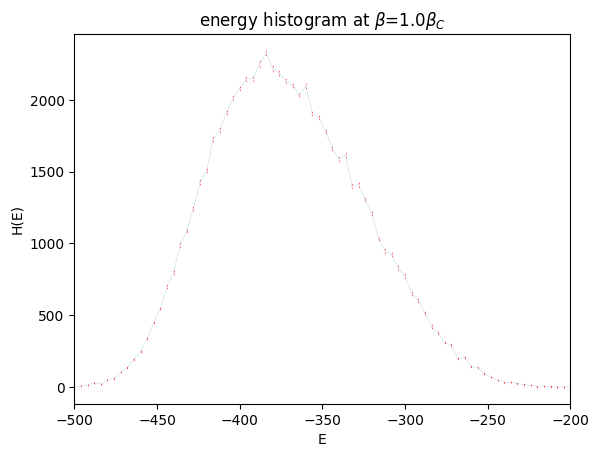

average relative standard error:  3.2126402203874647 %
4.618306370485068


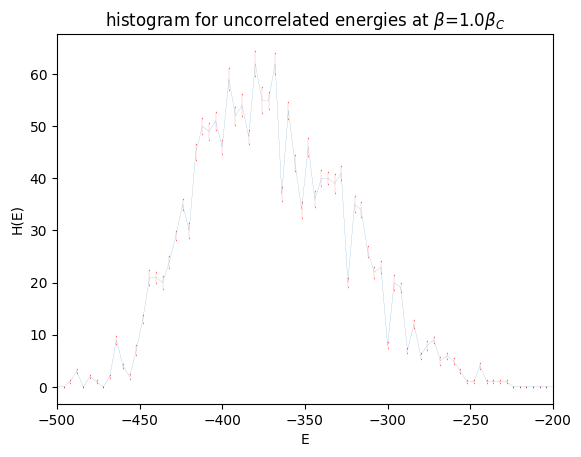

average relative standard error:  7.1823685165972275 %
3.899774447149604
6.37170764358541 0.061797075925504895
6.37170764358541 [0.         0.         0.34511002 0.27639566 0.         0.17387504
 0.13962521 0.         0.12208323 0.20842695 0.15770746 0.11174629
 0.19288096 0.1607974  0.15223599 0.12207182 0.09931022 0.18033303
 0.08585663 0.10021625 0.11661372 0.1021457  0.0995409  0.13485602
 0.12405656 0.1100693  0.12235585 0.13578344 0.10631823 0.09803499
 0.1357805  0.19544048 0.12163378 0.20128041 0.15119988 0.11216991
 0.15743924 0.15427537 0.15878059 0.1478973  0.12250887 0.09452637
 0.13135451 0.09893427 0.08472667 0.14890134 0.18343071 0.08381573
 0.09427823 0.09709328 0.04685593 0.12609511 0.10100053 0.05914788
 0.09081685 0.0855898  0.14167114 0.09105925 0.14885104 0.10178004
 0.14899149 0.11128733 0.09014836 0.09720429 0.26280434 0.16637807
 0.16399316 0.16654078 0.19211684 0.         0.         0.
 0.         0.         0.        ]


In [91]:
# Aufgabe 10
experiment_id = 6
measurement_id = 9 # 10 is also available 
paths = collect_data(experiment_id,measurement_id)
print("Datensätze: ",paths)

df,params = read_data_from_file(paths[0],experiment_id)

E_ts = df["E"][5001::].to_numpy()
sweeps  = len(E_ts)
L = params["length"]
dim = 2
beta = params["beta"]
beta_C = np.log(np.sqrt(2)+1)/2

E = np.mean(E_ts)
var_corr = np.var(E_ts)
t_int_binning = t_int__bin(E_ts,16)
t_int_E, d_t_int_E = t_int(E_ts)
step = int(t_int_E*2)+1
dE = np.sqrt(2*var_corr*t_int_E/sweeps)

E_ts_uncorr = E_ts[::step]
E_uncorr = np.mean(E_ts_uncorr)
var_uncorr = np.var(E_ts_uncorr)
#print(var_uncorr/len(E_ts_uncorr),var_corr/len(E_ts))

H_E = np.zeros(int(L**dim*dim*2/4))
H_E_blocks = []

d_H_E = np.zeros(int(L**dim*dim*2/4))
t_int_H_E = np.zeros(int(L**dim*dim*2/4))


n_blocks = 16
block_size = int(len(E_ts)/n_blocks)
counter = 0
for energy in E_ts:
    bin_index = getBin(energy,L,dim)
    H_E[bin_index] += 1

    if counter % block_size == 0:
        H_E_blocks.append(np.zeros(int(L**dim*dim*2/4)))
    H_E_blocks[-1][bin_index] += 1
    counter += 1
for i in range(len(H_E)):
    variance = np.var([H_E_blocks[j][i] for j in range(len(H_E_blocks))])
    d_H_E[i] = np.sqrt(variance) # TODO error plausible?
    #t_int_H_E[i],_ = t_int(H_E_blocks[j][i] for j in range(len(H_E_blocks)))
    ts = [H_E_blocks[j][i] for j in range(len(H_E_blocks))]
   #docsd_H_E_jk = jackknife(ts,np.mean,len(ts))
#print(d_H_E_jk)

H_E_uncorr = np.zeros(int(L**dim*dim*2/4))
d_H_E_uncorr = np.zeros(int(L**dim*dim*2/4))
H_E_uncorr_blocks = []
n_blocks = 16


block_size = int(len(E_ts_uncorr)/n_blocks)
counter = 0
for energy in E_ts_uncorr:
    bin_index = getBin(energy,L,dim)
    if counter % block_size == 0:
        H_E_uncorr_blocks.append(np.zeros(int(L**dim*dim*2/4)))
    H_E_uncorr[bin_index] += 1
    H_E_uncorr_blocks[-1][bin_index] += 1

    counter += 1
for i in range(len(H_E_uncorr)):
    variance = np.var([H_E_uncorr_blocks[j][i] for j in range(len(H_E_uncorr_blocks))])
    d_H_E_uncorr[i] = np.sqrt(variance) # TODO error plausible?




print("mittlere Energie:" ,E,"+-",dE)
print("A(k)-estimate for t_int:",t_int_E, "+-",d_t_int_E)
print("binning estimate for t_int:",t_int_binning)

# print histograms

import matplotlib.pyplot as plt

binnames = [energy_map(i,L,dim) for i in range(len(H_E))]
plt.errorbar(binnames,H_E,yerr=d_H_E,linewidth=0.1,capsize=0.2,markersize=0.2,ecolor="red")
plt.xlabel("E")
plt.ylabel("H(E)")
plt.xlim(-500,-200)
plt.title(r"energy histogram at $\beta$="+str(round(beta/beta_C,2))+r"$\beta_C$")
plt.show()

u = getBin(-500,L,dim)
o = getBin(-200,L,dim)
print("average relative standard error: ",np.mean(d_H_E[u:o]/(H_E[u:o]+0.1))*100,"%")
print(np.std(d_H_E[u:o]/(H_E[u:o]+0.1))*100)


plt.errorbar(binnames,H_E_uncorr,yerr=d_H_E_uncorr,linewidth=0.1,capsize=0.2,markersize=0.2,ecolor="red")
plt.xlabel("E")
plt.ylabel("H(E)")
plt.xlim(-500,-200)
plt.title(r"histogram for uncorrelated energies at $\beta$="+str(round(beta/beta_C,2))+r"$\beta_C$")
plt.show()

u = getBin(-500,L,dim)
o = getBin(-200,L,dim)
print("average relative standard error: ",np.mean(d_H_E_uncorr[u:o]/(H_E_uncorr[u:o]+0.1))*100,"%")
print(np.std(d_H_E_uncorr[u:o]/(H_E_uncorr[u:o]+1))*100)



print(np.sqrt(2*t_int_E),np.std(d_H_E_uncorr[u:o]/(d_H_E[u:o]+0.1)))
print(np.sqrt(2*t_int_E),d_H_E_uncorr[u:o]/(d_H_E[u:o]))





